# The Option-Critic Architecture

Simple implementation of the [Option-Critic Architecture](https://arxiv.org/abs/1609.05140) on the Four-rooms environment.

### 1 Import Libraries and Modules

In [1]:
from fourrooms import FourRooms
from utils import *

In [2]:
from time import sleep

In [3]:
import numpy as np

In [4]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

### 2 Test Environment

Taking a look at how the environment looks like.

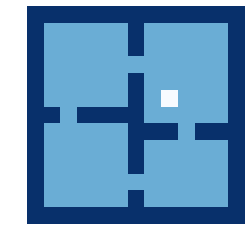

In [5]:
env = FourRooms()
env.reset()

clear_output(True)
plt.imshow(env.render(show_goal=False), cmap='Blues')
plt.axis('off')
plt.show()

Runing a few random iterations to observe how the agents behavior.

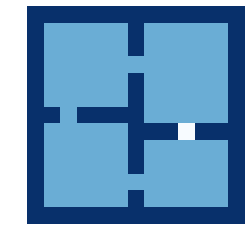

In [6]:
nsteps = 100
nactions = env.action_space.shape[0]

for step in range(nsteps):
    
    action = np.random.randint(nactions)
    
    state, reward, done, _ = env.step(action)
    
    clear_output(True)
    plt.imshow(env.render(show_goal=False), cmap='Blues')
    plt.axis('off')
    plt.show()

### 3 Train using Option-Critic

Setting the hyperparameters.

In [7]:
# Discount
discount = 0.99

# Learning rates - termination, intra-option, critic
lr_term = 0.25
lr_intra = 0.25
lr_critic = 0.5

# Epsilon for epsilon-greedy for policy over options
epsilon = 1e-1

# Temperature for softmax
temperature = 1e-2

# Number of runs
nruns = 10

# Number of episodes per run
nepisodes = 1000

# Maximum number of steps per episode
nsteps = 1000

# Number of options
noptions = 4

In [8]:
# Random number generator for reproducability
rng = np.random.RandomState(1234)

# The possible next goals (all in the lower right room)
possible_next_goals = [68, 69, 70, 71, 72, 78, 79, 80, 81, 82, 88, 89, 90, 91, 92, 93, 99, 100, 101, 102, 103]

The main loop for training.

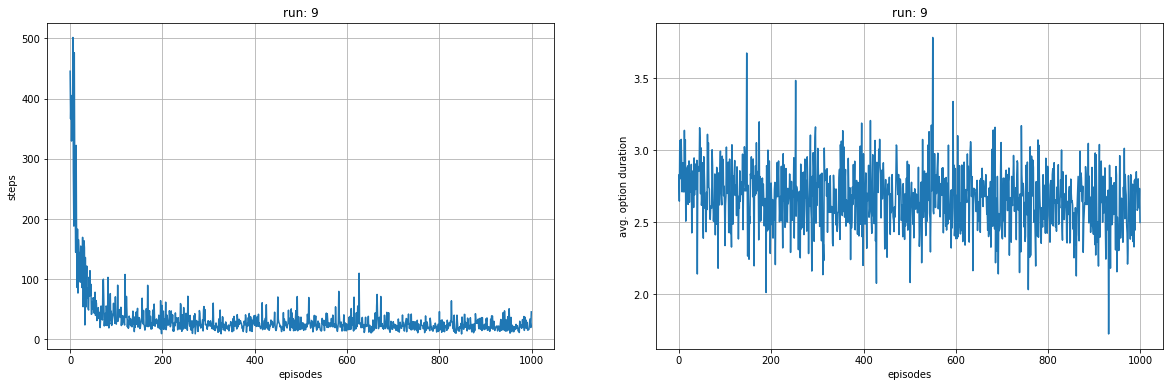

In [9]:
# History of steps and average durations
history = np.zeros((nruns, nepisodes, 2))

option_terminations_list = []

for run in range(nruns):
    
    env = FourRooms()
    
    nstates = env.observation_space.shape[0]
    nactions = env.action_space.shape[0]
    
    # Following three belong to the Actor
    
    # 1. The intra-option policies - linear softmax functions
    option_policies = [SoftmaxPolicy(rng, lr_intra, nstates, nactions, temperature) for _ in range(noptions)]
    
    # 2. The termination function - linear sigmoid function
    option_terminations = [SigmoidTermination(rng, lr_term, nstates) for _ in range(noptions)]
    
    # 3. The epsilon-greedy policy over options
    policy_over_options = EpsGreedyPolicy(rng, nstates, noptions, epsilon)
    
    # Critic
    critic = Critic(lr_critic, discount, policy_over_options.Q_Omega_table, nstates, noptions, nactions)
    
    print('Goal: ', env.goal)
    
    for episode in range(nepisodes):
        
        # Change goal location after 1000 episodes 
        # Comment it for not doing transfer experiments
        if episode == 1000:
            env.goal = rng.choice(possible_next_goals)
            print('New goal: ', env.goal)
        
        state = env.reset()
        
        option = policy_over_options.sample(state)
        action = option_policies[option].sample(state)
        
        critic.cache(state, option, action)
        
        duration = 1
        option_switches = 0
        avg_duration = 0.0
        
        for step in range(nsteps):
            
            state, reward, done, _ = env.step(action)
            
            # Termination might occur upon entering new state
            if option_terminations[option].sample(state):
                option = policy_over_options.sample(state)
                option_switches += 1
                avg_duration += (1.0/option_switches)*(duration - avg_duration)
                duration = 1
                
            action = option_policies[option].sample(state)
            
            # Critic update
            critic.update_Qs(state, option, action, reward, done, option_terminations)
            
            # Intra-option policy update with baseline
            Q_U = critic.Q_U(state, option, action)
            Q_U = Q_U - critic.Q_Omega(state, option)
            option_policies[option].update(state, action, Q_U)
            
            # Termination condition update
            option_terminations[option].update(state, critic.A_Omega(state, option))
            
            duration += 1
            
            if done:
                break
                
        history[run, episode, 0] = step
        history[run, episode, 1] = avg_duration
        
    option_terminations_list.append(option_terminations)
    
    # Plot stuff
    clear_output(True)
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    plt.title('run: %s' % run)
    plt.xlabel('episodes')
    plt.ylabel('steps')
    plt.plot(np.mean(history[:run+1,:,0], axis=0))
    plt.grid(True)
    plt.subplot(122)
    plt.title('run: %s' % run)
    plt.xlabel('episodes')
    plt.ylabel('avg. option duration')
    plt.plot(np.mean(history[:run+1,:,1], axis=0))
    plt.grid(True)
    plt.show()

Displaying termination probabilities.

Run: 9


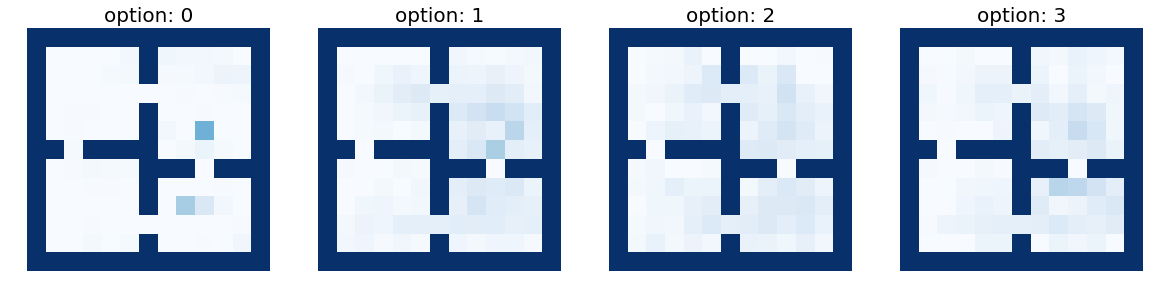

In [10]:
for run in range(nruns):
    
    termination_maps = [env.occupancy.astype('float64') for _ in range(noptions)]
    
    for option in range(noptions):
        state = 0
        for i in range(13):
            for j in range(13):
                if termination_maps[option][i,j] == 0:
                    termination_maps[option][i,j] = option_terminations_list[run][option].pmf(state)
                    state += 1

    clear_output(True)
    print('Run: {}'.format(run))
    plt.figure(figsize=(20,5))
    plt.subplot(141)
    plt.title('option: 0', fontsize=20)
    plt.imshow(termination_maps[0], cmap='Blues')
    plt.axis('off')
    plt.subplot(142)
    plt.title('option: 1', fontsize=20)
    plt.imshow(termination_maps[1], cmap='Blues')
    plt.axis('off')
    plt.subplot(143)
    plt.title('option: 2', fontsize=20)
    plt.imshow(termination_maps[2], cmap='Blues')
    plt.axis('off')
    plt.subplot(144)
    plt.title('option: 3', fontsize=20)
    plt.imshow(termination_maps[3], cmap='Blues')
    plt.axis('off')
    plt.show()
    sleep(2)

### 4 Test the Agent

The goal is the east doorway.

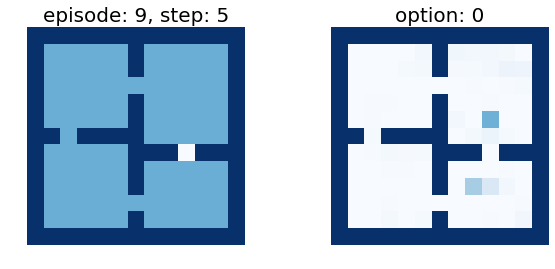

Goal reached!


In [11]:
# Turn off exploration while testing
policy_over_options.epsilon = 0
for option in range(noptions):
    option_policies[option].temperature = 1e-10

env = FourRooms()

nepisodes = 10

rng = np.random.RandomState(1234)

for episode in range(nepisodes):

    state = env.reset()

    option = policy_over_options.sample(state)

    for step in range(nsteps):
        
        action = option_policies[option].sample(state)
        
        state, reward, done, _ = env.step(action)

        # Termination might occur upon entering new state
        if option_terminations[option].sample(state):
            option = policy_over_options.sample(state)
        
        clear_output(True)
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.title('episode: {}, step: {}'.format(episode, step), fontsize=20)
        plt.imshow(env.render(), cmap='Blues', )
        plt.axis('off')
        plt.subplot(122)
        plt.title('option: %s' %option, fontsize=20)
        plt.imshow(termination_maps[option], cmap='Blues')
        plt.axis('off')
        plt.show()

        if done:
            break
    
    print("Goal reached!")
    sleep(2)